In [59]:
import pandas as pd
import os

In [60]:
options_df = pd.read_csv('data/clean/SPY_2023_eod.csv', index_col=0, parse_dates=True)

In [61]:
options_df.head()

,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,C_BID,C_ASK,C_IV,C_DELTA,C_GAMMA,...,P_ASK,P_IV,P_DELTA,P_GAMMA,P_THETA,P_VEGA,P_RHO,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,16.0,456.45,2023-08-01,0.0,370.0,86.49,86.58,3.61938,0.97443,0.00340,...,0.01,1.34825,-0.00084,0.00003,-0.00491,0.00060,0.00000,0.0,86.4,0.189
2023-08-01,16.0,456.45,2023-08-01,0.0,380.0,76.49,76.58,3.26940,0.97349,0.00422,...,0.01,1.17318,-0.00126,0.00015,-0.00504,0.00083,0.00000,0.0,76.4,0.167
2023-08-01,16.0,456.45,2023-08-01,0.0,388.0,68.49,68.59,3.00529,0.97023,0.00503,...,0.01,1.03520,-0.00132,0.00014,-0.00463,0.00069,-0.00022,0.0,68.4,0.150
2023-08-01,16.0,456.45,2023-08-01,0.0,390.0,65.96,67.04,2.89604,0.97611,0.00541,...,0.01,1.00051,-0.00046,0.00013,-0.00491,0.00050,0.00000,0.0,66.4,0.146
2023-08-01,16.0,456.45,2023-08-01,0.0,395.0,60.96,62.03,2.72683,0.97421,0.00609,...,0.01,0.91580,-0.00140,0.00018,-0.00473,0.00034,-0.00019,0.0,61.4,0.135


In [62]:
options_df.columns

Index(['QUOTE_TIME_HOURS', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'STRIKE',
       'C_BID', 'C_ASK', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_THETA', 'C_VEGA',
       'C_RHO', 'C_VOLUME', 'P_BID', 'P_ASK', 'P_IV', 'P_DELTA', 'P_GAMMA',
       'P_THETA', 'P_VEGA', 'P_RHO', 'P_VOLUME', 'STRIKE_DISTANCE',
       'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [63]:
len(options_df)

578743

In [64]:
#starting with the volatility surface builder

In [65]:
#for a given date, we need to build the volatility surface for a given stock
options_df.loc['2023-08-01']

,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,C_BID,C_ASK,C_IV,C_DELTA,C_GAMMA,...,P_ASK,P_IV,P_DELTA,P_GAMMA,P_THETA,P_VEGA,P_RHO,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,16.0,456.45,2023-08-01,0.00,370.0,86.49,86.58,3.61938,0.97443,0.00340,...,0.01,1.34825,-0.00084,0.00003,-0.00491,0.00060,0.00000,0.0,86.4,0.189
2023-08-01,16.0,456.45,2023-08-01,0.00,380.0,76.49,76.58,3.26940,0.97349,0.00422,...,0.01,1.17318,-0.00126,0.00015,-0.00504,0.00083,0.00000,0.0,76.4,0.167
2023-08-01,16.0,456.45,2023-08-01,0.00,388.0,68.49,68.59,3.00529,0.97023,0.00503,...,0.01,1.03520,-0.00132,0.00014,-0.00463,0.00069,-0.00022,0.0,68.4,0.150
2023-08-01,16.0,456.45,2023-08-01,0.00,390.0,65.96,67.04,2.89604,0.97611,0.00541,...,0.01,1.00051,-0.00046,0.00013,-0.00491,0.00050,0.00000,0.0,66.4,0.146
2023-08-01,16.0,456.45,2023-08-01,0.00,395.0,60.96,62.03,2.72683,0.97421,0.00609,...,0.01,0.91580,-0.00140,0.00018,-0.00473,0.00034,-0.00019,0.0,61.4,0.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,16.0,456.45,2025-12-19,871.04,505.0,39.50,44.50,0.17774,0.48796,0.00304,...,58.50,0.14575,-0.66212,0.00682,-0.00672,2.10125,-2.69652,0.0,48.6,0.106
2023-08-01,16.0,456.45,2025-12-19,871.04,510.0,37.00,42.00,0.17422,0.47279,0.00307,...,61.50,0.14219,-0.70354,0.00720,-0.00600,1.93288,-2.49139,4.0,53.6,0.117
2023-08-01,16.0,456.45,2025-12-19,871.04,515.0,34.50,39.50,0.17174,0.45660,0.00313,...,64.50,0.13810,-0.75625,0.00791,-0.00466,1.68427,-2.16575,0.0,58.6,0.128


In [66]:
options_df_per_date = options_df.loc['2023-08-01']

In [67]:
options_df_per_date.head()

,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,C_BID,C_ASK,C_IV,C_DELTA,C_GAMMA,...,P_ASK,P_IV,P_DELTA,P_GAMMA,P_THETA,P_VEGA,P_RHO,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,16.0,456.45,2023-08-01,0.0,370.0,86.49,86.58,3.61938,0.97443,0.00340,...,0.01,1.34825,-0.00084,0.00003,-0.00491,0.00060,0.00000,0.0,86.4,0.189
2023-08-01,16.0,456.45,2023-08-01,0.0,380.0,76.49,76.58,3.26940,0.97349,0.00422,...,0.01,1.17318,-0.00126,0.00015,-0.00504,0.00083,0.00000,0.0,76.4,0.167
2023-08-01,16.0,456.45,2023-08-01,0.0,388.0,68.49,68.59,3.00529,0.97023,0.00503,...,0.01,1.03520,-0.00132,0.00014,-0.00463,0.00069,-0.00022,0.0,68.4,0.150
2023-08-01,16.0,456.45,2023-08-01,0.0,390.0,65.96,67.04,2.89604,0.97611,0.00541,...,0.01,1.00051,-0.00046,0.00013,-0.00491,0.00050,0.00000,0.0,66.4,0.146
2023-08-01,16.0,456.45,2023-08-01,0.0,395.0,60.96,62.03,2.72683,0.97421,0.00609,...,0.01,0.91580,-0.00140,0.00018,-0.00473,0.00034,-0.00019,0.0,61.4,0.135


In [68]:
options_df_per_date.columns


Index(['QUOTE_TIME_HOURS', 'UNDERLYING_LAST', 'EXPIRE_DATE', 'DTE', 'STRIKE',
       'C_BID', 'C_ASK', 'C_IV', 'C_DELTA', 'C_GAMMA', 'C_THETA', 'C_VEGA',
       'C_RHO', 'C_VOLUME', 'P_BID', 'P_ASK', 'P_IV', 'P_DELTA', 'P_GAMMA',
       'P_THETA', 'P_VEGA', 'P_RHO', 'P_VOLUME', 'STRIKE_DISTANCE',
       'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [69]:
# Remove ultra-low liquidity contracts
df = options_df_per_date
df = df[df["C_VOLUME"] > 5]
df = df[df["P_VOLUME"] > 5]


In [70]:
options_df_per_date = options_df_per_date[['EXPIRE_DATE', 'STRIKE', 'C_IV', 'P_IV', 'UNDERLYING_LAST']]

In [71]:
options_df_per_date.head()

,EXPIRE_DATE,STRIKE,C_IV,P_IV,UNDERLYING_LAST
QUOTE_DATE,,,,,
2023-08-01,2023-08-01,370.0,3.61938,1.34825,456.45
2023-08-01,2023-08-01,380.0,3.26940,1.17318,456.45
2023-08-01,2023-08-01,388.0,3.00529,1.03520,456.45
2023-08-01,2023-08-01,390.0,2.89604,1.00051,456.45
2023-08-01,2023-08-01,395.0,2.72683,0.91580,456.45


In [72]:
def moneyness(strike, underlying_last):
    moneyness = strike/underlying_last
    return moneyness

options_df_per_date['MONEYNESS'] = options_df_per_date.apply(lambda row: moneyness(row['STRIKE'], row['UNDERLYING_LAST']), axis=1)
options_df_per_date.head()



,EXPIRE_DATE,STRIKE,C_IV,P_IV,UNDERLYING_LAST,MONEYNESS
QUOTE_DATE,,,,,,
2023-08-01,2023-08-01,370.0,3.61938,1.34825,456.45,0.810604
2023-08-01,2023-08-01,380.0,3.26940,1.17318,456.45,0.832512
2023-08-01,2023-08-01,388.0,3.00529,1.03520,456.45,0.850038
2023-08-01,2023-08-01,390.0,2.89604,1.00051,456.45,0.854420
2023-08-01,2023-08-01,395.0,2.72683,0.91580,456.45,0.865374


In [73]:
# #visualiziing the volatility smile
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(options_df_per_date['MONEYNESS'], options_df_per_date['C_IV'], label='Call Implied Volatility', alpha=0.6)
# plt.plot(options_df_per_date['MONEYNESS'], options_df_per_date['P_IV'], label='Put Implied Volatility', alpha=0.6)
# plt.xlabel('Moneyness')
# plt.ylabel('Implied Volatility')
# plt.title('Volatility Smile')
# plt.legend()
# plt.show()




In [74]:
df = options_df_per_date 

In [75]:
df = df[ (df['C_IV'] > 0) & (df['C_IV'] <1) ]
df = df[ (df['P_IV'] > 0) & (df['P_IV'] <1) ]

In [76]:
df = df.sort_values(by='MONEYNESS')
df = df[ (df["MONEYNESS"] > 0.85) & (df["MONEYNESS"] < 1.15)]


In [77]:
import matplotlib.pyplot as plt

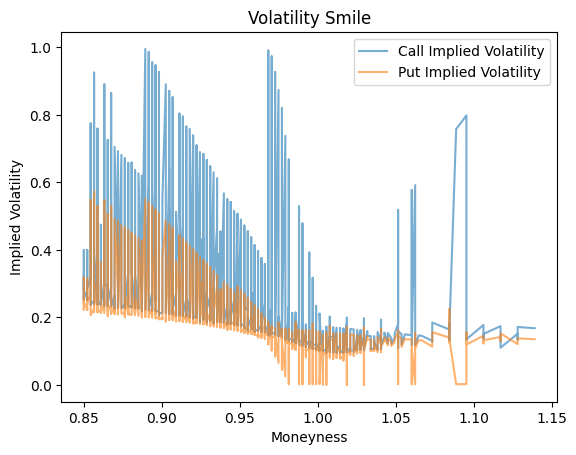

In [78]:
plt.plot(df['MONEYNESS'], df['C_IV'], label='Call Implied Volatility', alpha=0.6)
plt.plot(df['MONEYNESS'], df['P_IV'], label='Put Implied Volatility', alpha=0.6)
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smile')
plt.legend()
plt.show()

In [79]:
options_df.head()

,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,C_BID,C_ASK,C_IV,C_DELTA,C_GAMMA,...,P_ASK,P_IV,P_DELTA,P_GAMMA,P_THETA,P_VEGA,P_RHO,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,16.0,456.45,2023-08-01,0.0,370.0,86.49,86.58,3.61938,0.97443,0.00340,...,0.01,1.34825,-0.00084,0.00003,-0.00491,0.00060,0.00000,0.0,86.4,0.189
2023-08-01,16.0,456.45,2023-08-01,0.0,380.0,76.49,76.58,3.26940,0.97349,0.00422,...,0.01,1.17318,-0.00126,0.00015,-0.00504,0.00083,0.00000,0.0,76.4,0.167
2023-08-01,16.0,456.45,2023-08-01,0.0,388.0,68.49,68.59,3.00529,0.97023,0.00503,...,0.01,1.03520,-0.00132,0.00014,-0.00463,0.00069,-0.00022,0.0,68.4,0.150
2023-08-01,16.0,456.45,2023-08-01,0.0,390.0,65.96,67.04,2.89604,0.97611,0.00541,...,0.01,1.00051,-0.00046,0.00013,-0.00491,0.00050,0.00000,0.0,66.4,0.146
2023-08-01,16.0,456.45,2023-08-01,0.0,395.0,60.96,62.03,2.72683,0.97421,0.00609,...,0.01,0.91580,-0.00140,0.00018,-0.00473,0.00034,-0.00019,0.0,61.4,0.135


In [80]:
options_df.index

DatetimeIndex(['2023-08-01', '2023-08-01', '2023-08-01', '2023-08-01',
               '2023-08-01', '2023-08-01', '2023-08-01', '2023-08-01',
               '2023-08-01', '2023-08-01',
               ...
               '2023-11-30', '2023-11-30', '2023-11-30', '2023-11-30',
               '2023-11-30', '2023-11-30', '2023-11-30', '2023-11-30',
               '2023-11-30', '2023-11-30'],
              dtype='datetime64[ns]', name='QUOTE_DATE', length=578743, freq=None)

In [81]:
dates_strings = options_df.index.strftime('%Y-%m-%d')

In [82]:
dates_strings

Index(['2023-08-01', '2023-08-01', '2023-08-01', '2023-08-01', '2023-08-01',
       '2023-08-01', '2023-08-01', '2023-08-01', '2023-08-01', '2023-08-01',
       ...
       '2023-11-30', '2023-11-30', '2023-11-30', '2023-11-30', '2023-11-30',
       '2023-11-30', '2023-11-30', '2023-11-30', '2023-11-30', '2023-11-30'],
      dtype='object', name='QUOTE_DATE', length=578743)

In [83]:
dates_unique = dates_strings.unique()

In [84]:
dates_unique

Index(['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-07',
       '2023-08-08', '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-14',
       ...
       '2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21', '2023-11-22',
       '2023-11-24', '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30'],
      dtype='object', name='QUOTE_DATE', length=250)

In [85]:
date_unique_dates = dates_unique.tolist()

In [86]:
dates = date_unique_dates

In [87]:
options_df['MONEYNESS'] = options_df.apply(lambda row: moneyness(row['STRIKE'], row['UNDERLYING_LAST']), axis=1)

In [88]:
options_df.head()

,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,C_BID,C_ASK,C_IV,C_DELTA,C_GAMMA,...,P_IV,P_DELTA,P_GAMMA,P_THETA,P_VEGA,P_RHO,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,MONEYNESS
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,16.0,456.45,2023-08-01,0.0,370.0,86.49,86.58,3.61938,0.97443,0.00340,...,1.34825,-0.00084,0.00003,-0.00491,0.00060,0.00000,0.0,86.4,0.189,0.810604
2023-08-01,16.0,456.45,2023-08-01,0.0,380.0,76.49,76.58,3.26940,0.97349,0.00422,...,1.17318,-0.00126,0.00015,-0.00504,0.00083,0.00000,0.0,76.4,0.167,0.832512
2023-08-01,16.0,456.45,2023-08-01,0.0,388.0,68.49,68.59,3.00529,0.97023,0.00503,...,1.03520,-0.00132,0.00014,-0.00463,0.00069,-0.00022,0.0,68.4,0.150,0.850038
2023-08-01,16.0,456.45,2023-08-01,0.0,390.0,65.96,67.04,2.89604,0.97611,0.00541,...,1.00051,-0.00046,0.00013,-0.00491,0.00050,0.00000,0.0,66.4,0.146,0.854420
2023-08-01,16.0,456.45,2023-08-01,0.0,395.0,60.96,62.03,2.72683,0.97421,0.00609,...,0.91580,-0.00140,0.00018,-0.00473,0.00034,-0.00019,0.0,61.4,0.135,0.865374


In [89]:
options_df = options_df[['EXPIRE_DATE', 'STRIKE', 'C_IV', 'P_IV', 'UNDERLYING_LAST', 'MONEYNESS']]

In [90]:
options_df.head()

,EXPIRE_DATE,STRIKE,C_IV,P_IV,UNDERLYING_LAST,MONEYNESS
QUOTE_DATE,,,,,,
2023-08-01,2023-08-01,370.0,3.61938,1.34825,456.45,0.810604
2023-08-01,2023-08-01,380.0,3.26940,1.17318,456.45,0.832512
2023-08-01,2023-08-01,388.0,3.00529,1.03520,456.45,0.850038
2023-08-01,2023-08-01,390.0,2.89604,1.00051,456.45,0.854420
2023-08-01,2023-08-01,395.0,2.72683,0.91580,456.45,0.865374


In [92]:
options_df.index.dtype




dtype('<M8[ns]')

In [95]:
options_df.head()

,EXPIRE_DATE,STRIKE,C_IV,P_IV,UNDERLYING_LAST,MONEYNESS
QUOTE_DATE,,,,,,
2023-08-01,2023-08-01,370.0,3.61938,1.34825,456.45,0.810604
2023-08-01,2023-08-01,380.0,3.26940,1.17318,456.45,0.832512
2023-08-01,2023-08-01,388.0,3.00529,1.03520,456.45,0.850038
2023-08-01,2023-08-01,390.0,2.89604,1.00051,456.45,0.854420
2023-08-01,2023-08-01,395.0,2.72683,0.91580,456.45,0.865374


In [104]:
expire_dates=options_df['EXPIRE_DATE'].unique()

In [106]:
expire_dates=expire_dates.tolist()

In [107]:
df = options_df.loc[dates[0]]

In [111]:
df = df[df['EXPIRE_DATE'] == expire_dates[0]]

In [112]:
df.head()

,EXPIRE_DATE,STRIKE,C_IV,P_IV,UNDERLYING_LAST,MONEYNESS
QUOTE_DATE,,,,,,
2023-08-01,2023-08-01,370.0,3.61938,1.34825,456.45,0.810604
2023-08-01,2023-08-01,380.0,3.26940,1.17318,456.45,0.832512
2023-08-01,2023-08-01,388.0,3.00529,1.03520,456.45,0.850038
2023-08-01,2023-08-01,390.0,2.89604,1.00051,456.45,0.854420
2023-08-01,2023-08-01,395.0,2.72683,0.91580,456.45,0.865374


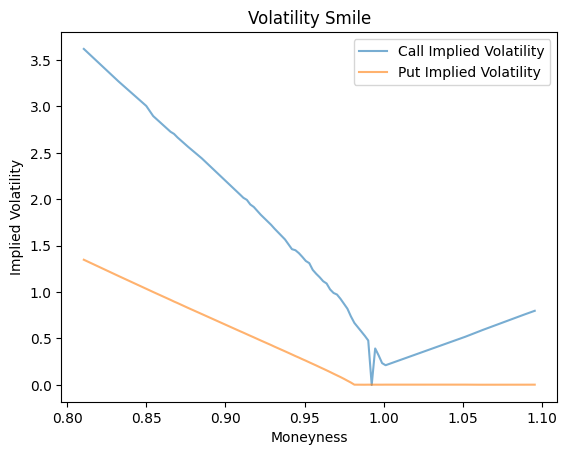

In [113]:
import matplotlib.pyplot as plt

In [151]:
class Smile:
    def __init__(self, quote_date, expire_date, df):
        self.df = df
        self.quote_date = quote_date
        self.expire_date = expire_date
        
    def plot_smile(self):
        plt.plot(self.df['MONEYNESS'], self.df['C_IV'], label='CALL IV')
        plt.plot(self.df['MONEYNESS'], self.df['P_IV'], label='PUT IV')
        plt.xlabel('Moneyness')
        plt.ylabel('Implied Volatility')
        plt.title('Volatility Smile')
        plt.legend()
        plt.show()

In [160]:
del df

In [161]:
del s

In [163]:
df = options_df.loc[dates[0]]

In [164]:
df = df[df['EXPIRE_DATE'] == expire_dates[0]]

In [168]:
#df.head()

In [166]:
s1 = Smile(dates[0], expire_dates[0], df)

In [ ]:
# temp = options_df.loc[dates[i]]
# temp = temp[temp['EXPIRE_DATE'] == expire_dates[j]]
# s[k] = Smile(dates[i], expire_dates[j], temp)
# del temp


In [171]:
s= []
for i in dates_unique:
    for j in expire_dates:
        temp = options_df.loc[i]
        temp = temp[temp['EXPIRE_DATE'] == j]
        s.append(Smile(i, j, temp))
        del temp

In [212]:
i=0
dict = {}
while (s[0].quote_date == s[i].quote_date):
    dict[s[i].expire_date] = s[i].df 
    i += 1

In [237]:
class VolatilitySurface(Smile):
    
    def __init__(self, quote_date):
        self.quote_date = quote_date
        self.smiles = {}
        
    def add_smile(self):
        
        i = 0
        while(s[i].quote_date != self.quote_date):
             i += 1
        
        self.smiles = {}
        while (s[i].quote_date == self.quote_date):
            self.smiles[s[i].expire_date] = s[i].df
            i += 1   
    
    def get_smile(self, expire_date):
        return self.smiles[expire_date]

In [ ]:
class VolSurfaceStore:
    def __init__(self):
        self.surfaces = {}
        
    def add_surface(self, quote_date):
        self.surfaces[quote_date] = VolatilitySurface(quote_date)
        self.surfaces[quote_date].add_smile()
    
    def get_surface(self, quote_date):
        return self.surfaces[quote_date]


In [269]:
del VS

In [274]:
del VS

In [275]:
VS = VolSurfaceStore()


In [276]:
for i in range(len(dates)):
    VS.add_surface(dates[i])

IndexError: list index out of range